In [7]:
import re
import os
import gc
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from IPython.display import Image
tqdm.pandas()
logging.basicConfig(level=logging.DEBUG)
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [8]:
# Image(filename = "Model_Structure.png")

In [9]:
"""
Load data
"""
df = pd.read_excel('medical_sieve_training_set_lower.xlsx')
df_t = pd.read_excel('medical_sieve_test_set_lower.xlsx')
df.info()
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 9 columns):
aspect                    18632 non-null object
course_of_problem         18632 non-null object
group                     18632 non-null object
id                        18632 non-null object
text                      18632 non-null object
trainOrtest               18632 non-null object
treatment                 18632 non-null object
ground_truth_subaspect    18632 non-null object
ground_truth_sentiment    18632 non-null int64
dtypes: int64(1), object(8)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
aspect                    4000 non-null object
course_of_problem         4000 non-null object
group                     4000 non-null object
id                        4000 non-null object
test                      4000 non-null object
text                      4000 non-null object
trainOrtest           

In [10]:
import re
def process(x):
    ans = set()
    for each in x[1:-1].split(','): 
        words = each.strip().strip('"').strip("'")
        m = re.match('(\w+)-', words)
        if m is not None:
            ans.add(m[1])
#         else:
#             ans.add(words)
    return list(ans)
df['ground_truth_aspect'] = df['ground_truth_subaspect'].apply(lambda x: process(x))
df_t['ground_truth_aspect'] = df_t['ground_truth_subaspect'].apply(lambda x: process(x))
df_dev = df_t[:2000]
df_test = df_t[2000:]

In [11]:
# from random import random
# for index, each in enumerate(df.loc[:]['ground_truth_aspect']):
#     if each == ['not about'] and random() > 0.5 :
#         df = df.drop(index=index)
df['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],12339
1,[access],2798
2,[costs],1617
3,[errors],1000
4,[delays],857
5,"[costs, access]",14
6,"[delays, access]",3
7,"[access, errors]",2
8,"[costs, errors]",1
9,"[costs, delays]",1


In [12]:
df_t['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],3106
1,[access],356
2,[costs],250
3,[delays],181
4,[errors],107


In [13]:
df_dev['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1571
1,[access],175
2,[costs],128
3,[delays],87
4,[errors],39


In [14]:
df_test['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1535
1,[access],181
2,[costs],122
3,[delays],94
4,[errors],68


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer


mlb_aspect = MultiLabelBinarizer()
mlb_aspect.fit(df['ground_truth_aspect'])
aspect_vectors_train = mlb_aspect.transform(df['ground_truth_aspect'])
aspect_vectors_dev = mlb_aspect.transform(df_dev['ground_truth_aspect'])
aspect_vectors_test = mlb_aspect.transform(df_test['ground_truth_aspect'])
print("Unique types of compliant:\n",mlb_aspect.classes_)

lb_sentiment = LabelBinarizer()
lb_sentiment.fit(list(df['ground_truth_sentiment']) + list(df_t['ground_truth_sentiment']))
sentiment_vectors_train = lb_sentiment.transform(df['ground_truth_sentiment'])
sentiment_vectors_dev = lb_sentiment.transform(df_dev['ground_truth_sentiment'])
sentiment_vectors_test = lb_sentiment.transform(df_test['ground_truth_sentiment'])

print("Unique sentiments: ",lb_sentiment.classes_)
lb_group = LabelBinarizer()
lb_group.fit(list(df['group']) + list(df_t['group']))
group_vectors_train = lb_group.transform(df['group'])
group_vectors_dev = lb_group.transform(df_dev['group'])
group_vectors_test = lb_group.transform(df_test['group'])

Unique types of compliant:
 ['access' 'costs' 'delays' 'errors']
Unique sentiments:  [0 1 2]


0    12078
1     6360
2      194
Name: ground_truth_sentiment, dtype: int64


Text(0, 0.5, 'count')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDis

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 2.777272727272727
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/jaden/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInter

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-SemiboldItalic.otf) italic normal semibold normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal heavy normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/jaden/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


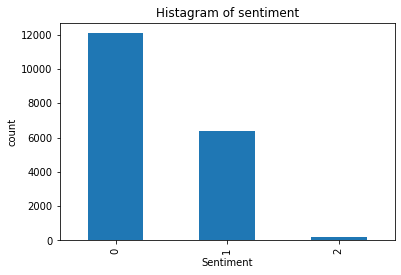

In [16]:
print(df['ground_truth_sentiment'].value_counts())
df['ground_truth_sentiment'].value_counts().plot.bar()
plt.title('Histagram of sentiment')
plt.xlabel('Sentiment')
plt.ylabel('count')

Text(0, 0.5, 'count')

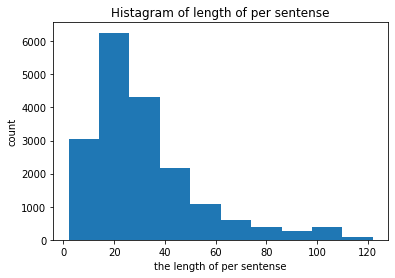

In [17]:
df['text'].apply(lambda x: len(x.split())).hist(grid=False)
plt.title('Histagram of length of per sentense')
plt.xlabel('the length of per sentense')
plt.ylabel('count')

In [18]:
MAX_SEQUENCE_LEN = 128
MAX_FEATURES = 481731
ASPECT_OUTPUT_DIM = len(mlb_aspect.classes_)
SENTIMENT_OUT_DIM = len(lb_sentiment.classes_)
GROUP_DIM = len(lb_group.classes_)
print("aspect_out_put: {}, senntiment_out_put: {}, group_dim: {}".format(ASPECT_OUTPUT_DIM, SENTIMENT_OUT_DIM, GROUP_DIM))

aspect_out_put: 4, senntiment_out_put: 3, group_dim: 276


In [19]:
"""
Fit tokenizer
"""
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
logging.info("Fitting Tokenizer")

tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=False)
# Updates internal vocabulary based on a list of texts
whole_text = []
with open('medical_sieve_sentence_corpus.txt', 'r') as f:
    for each in f.readlines():
        whole_text.append(each.strip())
f.close()
tokenizer.fit_on_texts(whole_text)

logging.info("Beginning process train text")
train_text = tokenizer.texts_to_sequences(df['text'])
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process dev text")
dev_text = tokenizer.texts_to_sequences(df_dev['text'])
dev_text = pad_sequences(dev_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process test text")
test_text = tokenizer.texts_to_sequences(df_test['text'])
test_text = pad_sequences(test_text, maxlen=MAX_SEQUENCE_LEN)

INFO:root:Fitting Tokenizer
INFO:root:Beginning process train text
INFO:root:Beginning process dev text
INFO:root:Beginning process test text


In [20]:
word_index = tokenizer.word_index
print('length:', len(word_index))
# del tokenizer
gc.collect()

length: 481731


20

In [21]:
"""
Get word Embedding
"""
EMB_PATH = "cbow_model_medical_sieve_lower.vec"
EMBEDDING_DIM = 300

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

# EMB_PATH  = "glove.840B.300d.txt"
# EMBEDDING_DIM = 300

# def load_embeddings(embedding_path=EMB_PATH):
#     '''return a dict whose key is word, value is pretrained word embedding'''
#     embeddings_index = {}
#     f = open(embedding_path, 'r', encoding='utf-8')
#     for line in f:
#         values = line.split()
#         try:
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coefs
#         except:
#             print("Err on ", values[:2])
#     f.close()
#     print('Total %s word vectors.' % len(embeddings_index))
#     return embeddings_index

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [22]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embeddings_index)
del embeddings_index
gc.collect()

92302it [00:04, 18554.49it/s]


20

In [23]:
from keras.engine import InputSpec, Layer
from keras import initializers
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [24]:
"""
Model builder
"""

from keras.layers import SpatialDropout1D, Bidirectional, Dense, LSTM
from keras.layers import Conv1D, Flatten, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda
from keras.layers import concatenate
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adagrad, Adam
from bpmll import bp_mll_loss
from keras import backend as K
from keras import optimizers

def build_model(verbose = True, compile = True):
    recurrent_units = 64
    input_layer = Input(shape=(MAX_SEQUENCE_LEN,))
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LEN,
                                trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.15)(embedding_layer)
    x = Bidirectional(LSTM(recurrent_units, return_sequences=True))(embedding_layer)
    x = Dropout(0.35)(x)
    x = Bidirectional(LSTM(recurrent_units, return_sequences=True))(x)

    last = Lambda(lambda t: t[:, -1])(x)
    maxpool = GlobalMaxPooling1D()(x)
    average = GlobalAveragePooling1D()(x)
    concatenated = concatenate([last, maxpool, average], axis=1)

    x = Dropout(0.5)(concatenated)
    x = Dense(72, activation="relu")(x)
    output_layer = Dense(ASPECT_OUTPUT_DIM, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [25]:
model = build_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
"""
Training Session
"""
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

BATCH_SIZE = 512
NUM_EPOCHS = 100


# class_weights = class_weight.compute_class_weight('balanced', mlb_aspect.classes_, df['ground_truth_aspect'].apply(lambda x: x[0]))

K.clear_session()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
model = build_model()
model.fit(x = train_text,
          y = aspect_vectors_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          validation_data = (dev_text,
                             aspect_vectors_dev),
          callbacks = [reduce_lr, es, checkpointer]
#           class_weight=class_weights
         )
model.load_weights('weights.hdf5')
# test_preds /= 5

Train on 18632 samples, validate on 2000 samples
Epoch 1/100
18632/18632 [==============================] - 125s 7ms/step - loss: 0.3081 - acc: 0.9049 - val_loss: 0.2024 - val_acc: 0.9464
Epoch 2/100
18632/18632 [==============================] - 124s 7ms/step - loss: 0.2336 - acc: 0.9182 - val_loss: 0.1621 - val_acc: 0.9400
Epoch 3/100
18632/18632 [==============================] - 120s 6ms/step - loss: 0.1875 - acc: 0.9268 - val_loss: 0.1316 - val_acc: 0.9489
Epoch 4/100
18632/18632 [==============================] - 116s 6ms/step - loss: 0.1600 - acc: 0.9350 - val_loss: 0.1437 - val_acc: 0.9386
Epoch 5/100
18632/18632 [==============================] - 115s 6ms/step - loss: 0.1423 - acc: 0.9425 - val_loss: 0.1274 - val_acc: 0.9449
Epoch 6/100
18632/18632 [==============================] - 115s 6ms/step - loss: 0.1303 - acc: 0.9478 - val_loss: 0.1437 - val_acc: 0.9324
Epoch 7/100
18632/18632 [==============================] - 115s 6ms/step - loss: 0.1213 - acc: 0.9504 - val_loss: 0.1

In [27]:
import copy
def combinations(nums):
    ans = [[]]
    for row in nums:
        curr = []
        for combination in ans:
            for element in row:
                new_combination = copy.deepcopy(combination)
                new_combination.append(element)
                curr.append(new_combination)
        ans = curr
    return ans
thresholds = [[0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55] for each in range(4)]
thresholds_set = combinations(thresholds)

In [28]:
val_preds = model.predict(dev_text)
aspect_vectors = aspect_vectors_dev

In [29]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score

def f1(matrix):
    precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
    recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
    return 2*((precision*recall)/(precision+recall))

max_avg_f1 = 0
max_hamming_score = 0
max_exact_accuracy = 0
max_fuzzy_accuracy = 0
max_fuzzy_accuracy_pos = 0
max_exact_accuracy_pos = 0
max_avg_rocauc = 0
max_confusion_matrix = None
max_threshold_set = []

for threshold_set in thresholds_set:
    predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each >= threshold_set[index]:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
    num_fuzzy_match = 0
    num_fuzzy_match_pos = 0
    num_exact_match_pos = 0
    num_pos = 0
    for pre, true, in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
        if len(true) != 0: 
            num_pos += 1
        intersect = set(pre).intersection(set(true))
        if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
            num_fuzzy_match += 1
        if len(true)>0 and len(pre)>0 and len(intersect) > 0:
            num_fuzzy_match_pos += 1
        if len(true)>0 and len(pre)>0 and pre == true: 
            num_exact_match_pos += 1
    fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
    exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
    fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
    exact_accuracy_pos = num_exact_match_pos*1.0/num_pos


    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
        
    rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
    if np.mean(class_f1) > max_avg_f1:
        max_threshold_set = threshold_set
        max_avg_f1 = max(max_avg_f1, np.mean(class_f1))
        max_hamming_score = hamming_score
        max_exact_accuracy = exact_accuracy
        max_fuzzy_accuracy = fuzzy_accuracy 
        max_exact_accuracy_pos = exact_accuracy_pos
        max_fuzzy_accuracy_pos = fuzzy_accuracy_pos
        max_avg_rocauc = rocauc_score
        max_confusion_matrix = multilabel_confusion_matrix(aspect_vectors, predict_softmax)
        
        

print("threshold set:", max_threshold_set)
print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(max_confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", max_hamming_score)
print("Exact accuracy:", max_exact_accuracy)
print("Fuzzy accuracy:", max_fuzzy_accuracy)
print("Exact accuracy (exclude negative):", max_exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", max_fuzzy_accuracy_pos)
print("Average F1 Score: ", max_avg_f1)
print("ROC AUC Score: ", max_avg_rocauc)

threshold set: [0.45, 0.55, 0.3, 0.55]
Confusion Matrix for Each Aspect:
[[[1674  151]
  [  38  137]]

 [[1808   64]
  [  42   86]]

 [[1840   73]
  [  35   52]]

 [[1943   18]
  [  28   11]]]
Result of Metrics for Evaluation:
Hamming score: 0.943875
Exact accuracy: 0.7845
Fuzzy accuracy: 0.7845
Exact accuracy (exclude negative): 0.4831081081081081
Fuzzy accuracy (exclude negative): 0.4831081081081081
Average F1 Score:  0.5061482855148128
ROC AUC Score:  0.9471125141338445


In [30]:
val_preds = model.predict(test_text)
aspect_vectors = aspect_vectors_test

In [31]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score

def f1(matrix):
    precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
    recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
    return 2*((precision*recall)/(precision+recall))

max_avg_f1 = 0
max_hamming_score = 0
max_exact_accuracy = 0
max_fuzzy_accuracy = 0
max_fuzzy_accuracy_pos = 0
max_exact_accuracy_pos = 0
max_avg_rocauc = 0
max_confusion_matrix = None
max_threshold_set = []

for threshold_set in thresholds_set:
    predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each >= threshold_set[index]:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
    num_fuzzy_match = 0
    num_fuzzy_match_pos = 0
    num_exact_match_pos = 0
    num_pos = 0
    for pre, true, in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
        if len(true) != 0: 
            num_pos += 1
        intersect = set(pre).intersection(set(true))
        if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
            num_fuzzy_match += 1
        if len(true)>0 and len(pre)>0 and len(intersect) > 0:
            num_fuzzy_match_pos += 1
        if len(true)>0 and len(pre)>0 and pre == true: 
            num_exact_match_pos += 1
    fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
    exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
    fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
    exact_accuracy_pos = num_exact_match_pos*1.0/num_pos


    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
        
    rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
    if np.mean(class_f1) > max_avg_f1:
        max_threshold_set = threshold_set
        max_avg_f1 = max(max_avg_f1, np.mean(class_f1))
        max_hamming_score = hamming_score
        max_exact_accuracy = exact_accuracy
        max_fuzzy_accuracy = fuzzy_accuracy 
        max_exact_accuracy_pos = exact_accuracy_pos
        max_fuzzy_accuracy_pos = fuzzy_accuracy_pos
        max_avg_rocauc = rocauc_score
        max_confusion_matrix = multilabel_confusion_matrix(aspect_vectors, predict_softmax)
        
        

print("threshold set:", max_threshold_set)
print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(max_confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", max_hamming_score)
print("Exact accuracy:", max_exact_accuracy)
print("Fuzzy accuracy:", max_fuzzy_accuracy)
print("Exact accuracy (exclude negative):", max_exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", max_fuzzy_accuracy_pos)
print("Average F1 Score: ", max_avg_f1)
print("ROC AUC Score: ", max_avg_rocauc)

threshold set: [0.45, 0.3, 0.55, 0.35]
Confusion Matrix for Each Aspect:
[[[1650  169]
  [  37  144]]

 [[1793   85]
  [  16  106]]

 [[1882   24]
  [  44   50]]

 [[1851   81]
  [  25   43]]]
Result of Metrics for Evaluation:
Hamming score: 0.939875
Exact accuracy: 0.7705
Fuzzy accuracy: 0.771
Exact accuracy (exclude negative): 0.48857142857142855
Fuzzy accuracy (exclude negative): 0.49
Average F1 Score:  0.5758667518128696
ROC AUC Score:  0.9448464111430716


In [40]:
"""
Training Session
"""
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

BATCH_SIZE = 1024
NUM_EPOCHS = 100
FOLDER_NUM = 5

class_weights = class_weight.compute_class_weight('balanced', lb_sentiment.classes_, df['ground_truth_sentiment'])

# splits = list(KFold(n_splits=FOLDER_NUM).split(train_text, aspect_vectors))
splits = list(KFold(n_splits=FOLDER_NUM, random_state=0).split(train_text, aspect_vectors_train))

# test_preds = np.zeros((test_text.shape[0]))
folders = [i for i in range(FOLDER_NUM)]

for folder in folders:
    K.clear_session()
    train_index, validate_index = splits[folder]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
    checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
    model = build_model()
    model.fit(x = [train_text[train_index], group_vectors_train[train_index]],
              y = aspect_vectors_train[train_index],
              batch_size = BATCH_SIZE,
              epochs = NUM_EPOCHS,
              validation_data = ([train_text[validate_index],group_vectors_train[validate_index]],
                                 aspect_vectors_train[validate_index]),
              callbacks = [reduce_lr, es, checkpointer]
#               class_weight=class_weights
             )
    val_preds = model.predict([train_text[validate_index],group_vectors_train[validate_index]])
    break
# test_preds /= 5

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[   0,    0,    0, ...,    2, 2079,  138],
       [   0,    0,    0, ...,   50,   10,  333],
       [   0,    0,    0, ...,  119, 2238,  694],
       ...,
       [   0,    0,    0, ...,  190, ...

In [156]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
for threshold in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    print('*'*20)
    print("Threshold:", threshold)
    print('*'*20)
    predict_softmax = np.zeros(aspect_vectors_train[validate_index].shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each > 0.09:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors_train[validate_index]) 
    acc = accuracy_score(predict_softmax, aspect_vectors_train[validate_index])
    fuzzy_acc = 0
    for pre, true, in zip(mlb_aspect.inverse_transform(predict_softmax), mlb_aspect.inverse_transform(aspect_vectors_train[validate_index])):
        intersect = set(pre).intersection(set(true))
        if intersect != None and len(intersect) > 0:
            fuzzy_acc += 1
    fuzzy_acc = fuzzy_acc*1.0 / len(predict_softmax)
    print("hamming score:", hamming_score)
    print("exact accuracy:", acc)
    print("fuzzy accuracy:", fuzzy_acc)


    def f1(matrix):
        precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
        recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
        return 2*((precision*recall)/(precision+recall))
    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors_train[validate_index], predict_softmax)):
        print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
    print("average f1 score: ", np.mean(class_f1))

********************
Threshold: 0.01
********************


NameError: name 'validate_index' is not defined